In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from bayes_opt import BayesianOptimization as BO
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

In [2]:
# load data for climate and groundwater level

df_climate_muddy_creek = pd.read_parquet('data/climate/df_climate_muddy_creek.parquet')
df_climate_pueblo = pd.read_parquet('data/climate/df_climate_pueblo.parquet')

df_gwl_muddy_creek = pd.read_parquet('data/gwl/df_gwl_muddy_creek.parquet')
df_gwl_pueblo = pd.read_parquet('data/gwl/df_gwl_pueblo.parquet')


In [3]:
df_climate_muddy_creek = df_climate_muddy_creek.dropna(axis=0)
df_climate_pueblo = df_climate_pueblo.dropna(axis=0)

df_climate_muddy_creek['day_date'] = df_climate_muddy_creek['date'].dt.date

df_climate_pueblo['day_date'] = df_climate_pueblo['date'].dt.date

df_gwl_muddy_creek['day_date'] = df_gwl_muddy_creek['datetime'].dt.date

df_gwl_pueblo['day_date'] = df_gwl_pueblo['datetime'].dt.date

In [4]:
# Find the minimum and maximum values of the date column in df_climate_muddy_creek
muddy_creek_min_date = df_climate_muddy_creek['day_date'].min()
muddy_creek_max_date = df_climate_muddy_creek['day_date'].max()

# Find the minimum and maximum values of the date column in df_climate_pueblo
pueblo_min_date = df_climate_pueblo['day_date'].min()
pueblo_max_date = df_climate_pueblo['day_date'].max()

# Print the results
print("df_climate_muddy_creek - Min Date:", muddy_creek_min_date)
print("df_climate_muddy_creek - Max Date:", muddy_creek_max_date)
print("df_climate_pueblo - Min Date:", pueblo_min_date)
print("df_climate_pueblo - Max Date:", pueblo_max_date)


df_climate_muddy_creek - Min Date: 2015-01-01
df_climate_muddy_creek - Max Date: 2022-12-31
df_climate_pueblo - Min Date: 2015-01-01
df_climate_pueblo - Max Date: 2022-12-31


In [5]:
def plot_precipitation_interpolation(df):
    fig, axs = plt.subplots(1, 2)
    df['precpinch'].plot(ax=axs[0], title='Before interpolation')
    df['precpinch'] = df['precpinch'].replace(0, np.nan)
    df['precpinch'] = df['precpinch'].interpolate(method='piecewise_polynomial', order=2, axis=0).ffill().bfill()
    df['precpinch'].plot(ax=axs[1], title='After interpolation')

def plot_temperature_interpolation(df):
    fig, axs = plt.subplots(1, 2)
    df['avgtempf'].plot(ax=axs[0], title='Before interpolation')
    df['avgtempf'] = df['avgtempf'].replace(0, np.nan)
    df['avgtempf'] = df['avgtempf'].interpolate(method='piecewise_polynomial', order=2, axis=0).ffill().bfill()
    df['avgtempf'].plot(ax=axs[1], title='After interpolation')


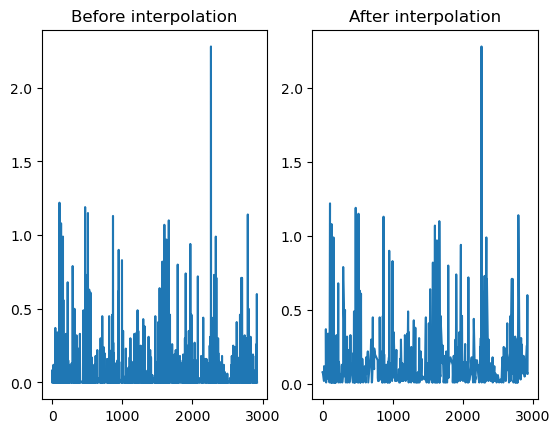

In [6]:
plot_precipitation_interpolation(df_climate_muddy_creek)

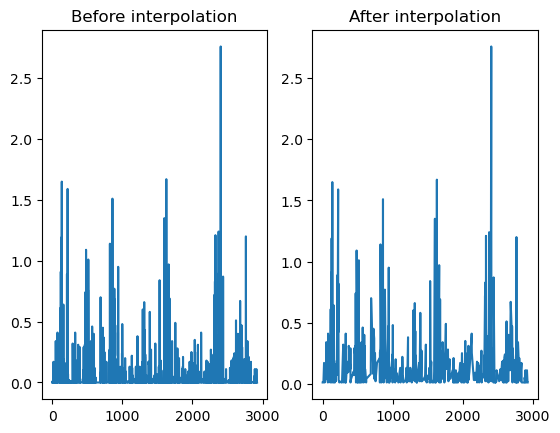

In [7]:
plot_precipitation_interpolation(df_climate_pueblo)

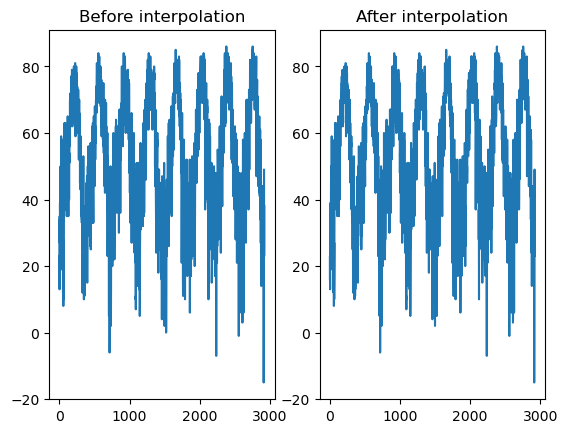

In [8]:
plot_temperature_interpolation(df_climate_muddy_creek)

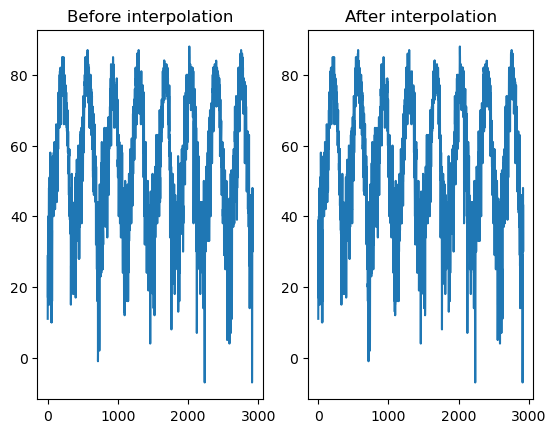

In [9]:
plot_temperature_interpolation(df_climate_pueblo)

In [10]:
(sum(df_gwl_muddy_creek['gwl']==0)>0) or (df_gwl_muddy_creek['gwl'].isna().sum()>0)

False

In [11]:
(sum(df_gwl_pueblo['gwl']==0)>0) or (df_gwl_pueblo['gwl'].isna().sum()>0)

False

### Build Model on Muddy Creek data

In [12]:
df_muddy_creek_data = df_climate_muddy_creek.merge(df_gwl_muddy_creek, on='day_date')

In [13]:
df_muddy_creek_data['tempf_mov_avg'] = df_muddy_creek_data['avgtempf'].rolling(7).sum()

In [14]:
df_muddy_creek_data['precpinch_mov_avg'] = df_muddy_creek_data['precpinch'].rolling(7).sum()

In [15]:
df_muddy_creek_data['gwl_mov_avg'] = df_muddy_creek_data['gwl'].rolling(7).sum()

In [16]:
x = df_muddy_creek_data[['precpinch', 'avgtempf']].values
y = df_muddy_creek_data['gwl'].values

# x = df_muddy_creek_data[['tempf_mov_avg', 'precpinch_mov_avg']].values
# y = df_muddy_creek_data['gwl_mov_avg'].values

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=False)

sc_climate = MinMaxScaler()
# sc_gwl = MinMaxScaler()

x_train = sc_climate.fit_transform(x_train)

x_val = sc_climate.transform(x_val)


In [17]:
def create_model(filter_size, act_function, neurons):

    input_tensor = tf.keras.layers.Input(shape=(x_train.shape[1],1))

    cnn = tf.keras.layers.Conv1D(filters=filter_size, kernel_size=2, activation=act_function, padding='same')(input_tensor) # convolutional layer, 32 filters, 3x3 kernel size, relu activation function

    cnn = tf.keras.layers.MaxPooling1D(pool_size=2,padding='same')(cnn) # max pooling layer, 2x downsampling

    cnn = tf.keras.layers.Dropout(0.3)(cnn) # dropout layer, 50% dropout

    # cnn = tf.keras.layers.Flatten()(cnn) # flatten layer, convert matrix to vector/

    cnn = tf.keras.layers.GlobalAveragePooling1D()(cnn) # global average pooling layer

    cnn = tf.keras.layers.Dense(neurons, activation='relu')(cnn) # dense layer, 32 neurons, relu activation function

    output = tf.keras.layers.Dense(1, activation='linear')(cnn) # dense layer, 1 neuron, linear activation function

    model = tf.keras.Model(inputs=input_tensor, outputs=output)

    optimiser = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.001, clipnorm=True) # Adam optimiser, learning rate 0.001, epsilon 1e-03

    model.compile(loss='mse', optimizer=optimiser, metrics=['mse']) # mean squared error loss function

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=3, restore_best_weights=True) # early stopping, monitor validation loss, 3 epochs patience, restore best weights

    rlrnop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1) # reduce learning rate on plateau, monitor validation loss, 0.5 factor, 1 epochs patience

    log = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=[es, rlrnop], verbose=0) # train model, 1000 epochs, batch size 32, early stopping

    loss = log.history['loss']
    val_loss = log.history['val_loss']

    plt.figure(figsize=(10, 6))
    plt.plot(loss, label='Training loss', color='blue')
    plt.plot(val_loss, label='Validation loss', color='red')
    plt.title('Training and Validation Loss for filter_size={}, act_function={}, neurons={}'.format(filter_size, act_function, neurons))
    plt.show()

    return model, log




Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 11.

Epoch 14: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 14: early stopping


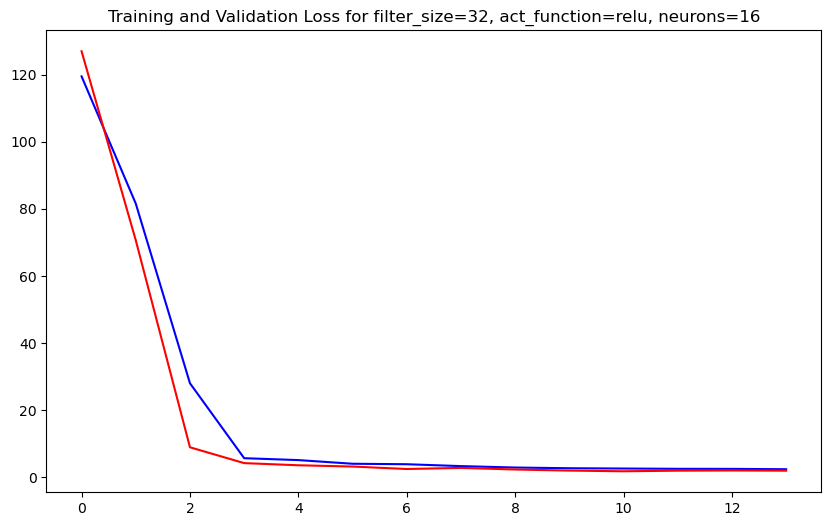


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 16: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 14.

Epoch 17: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 17: early stopping


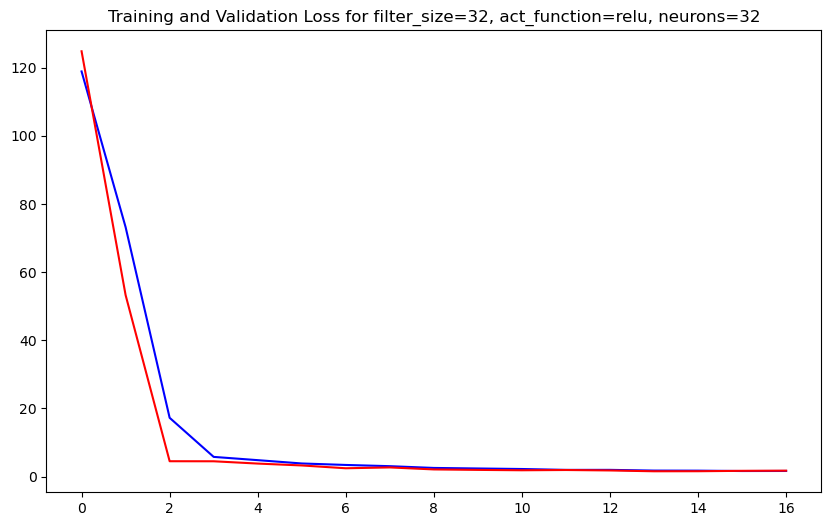


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 10.

Epoch 13: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 13: early stopping


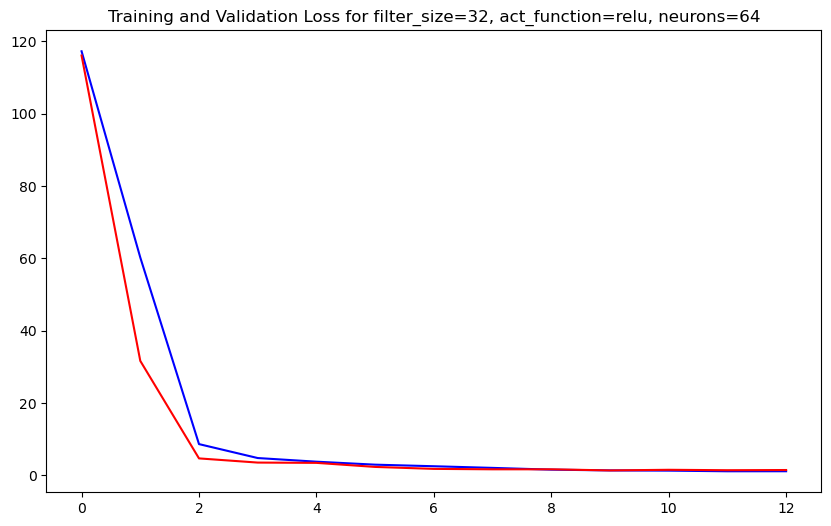


Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 4.

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 7: early stopping


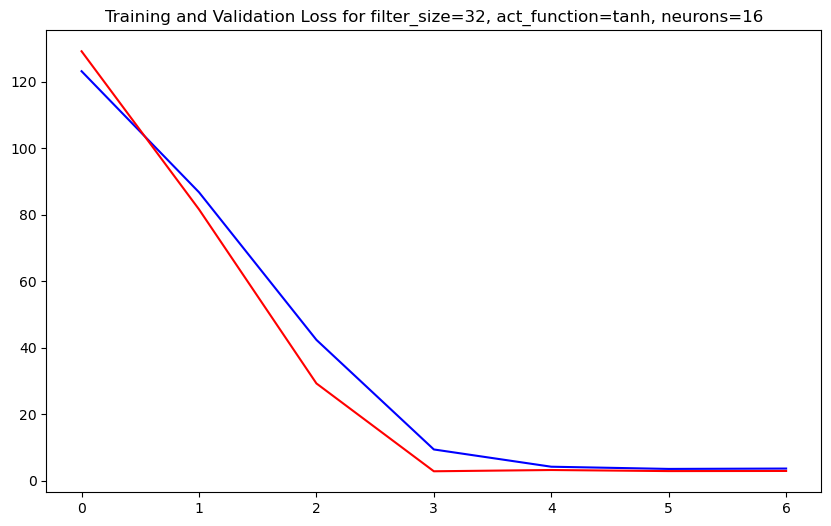


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 11.

Epoch 14: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 14: early stopping


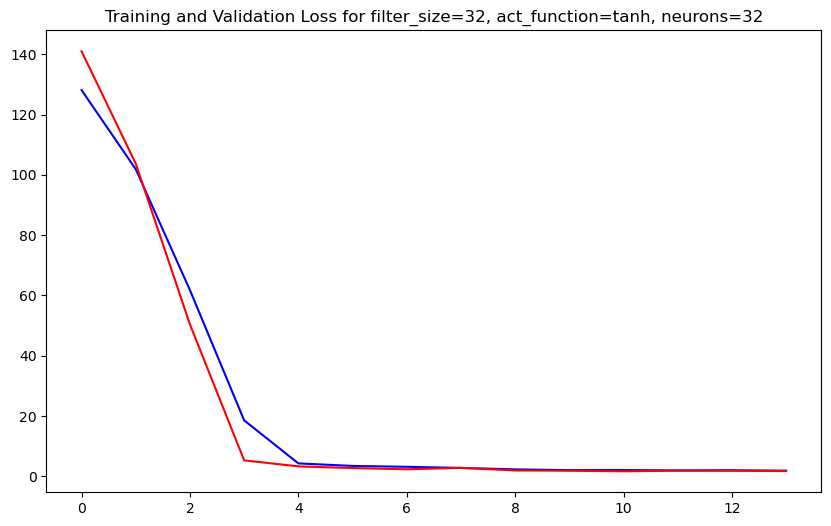


Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 13: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 11.

Epoch 14: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 14: early stopping


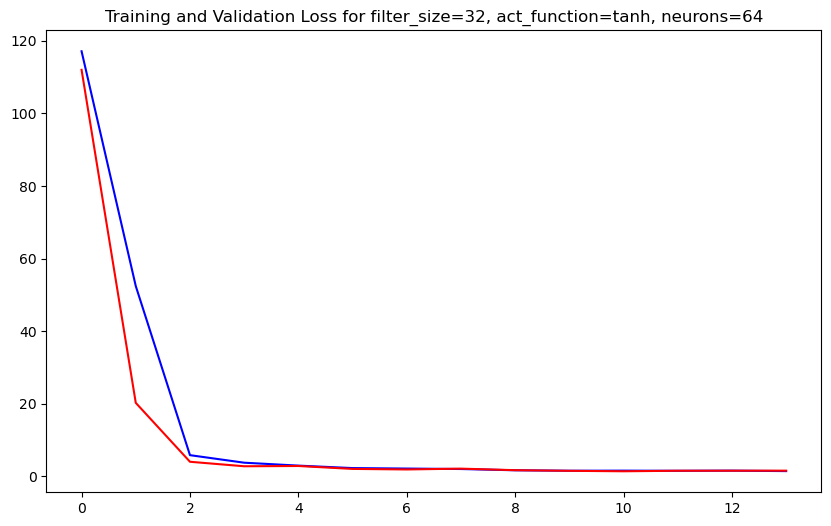


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 7.

Epoch 10: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 10: early stopping


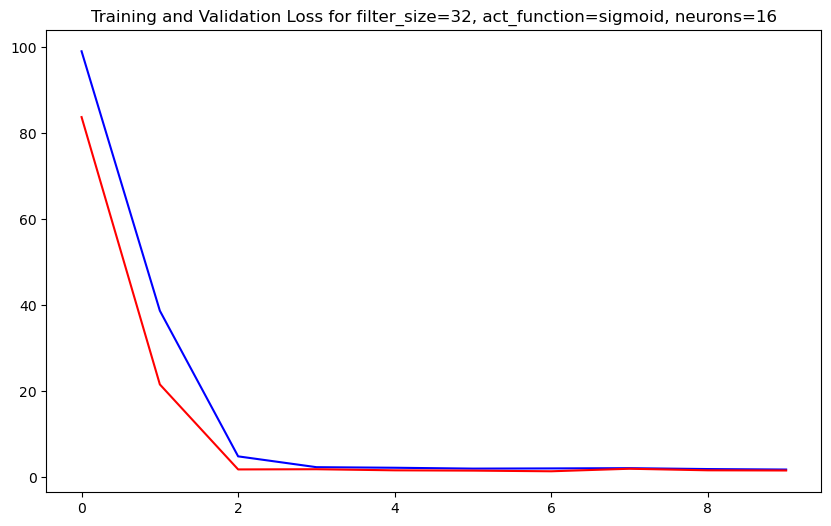


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 3.

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 6: early stopping


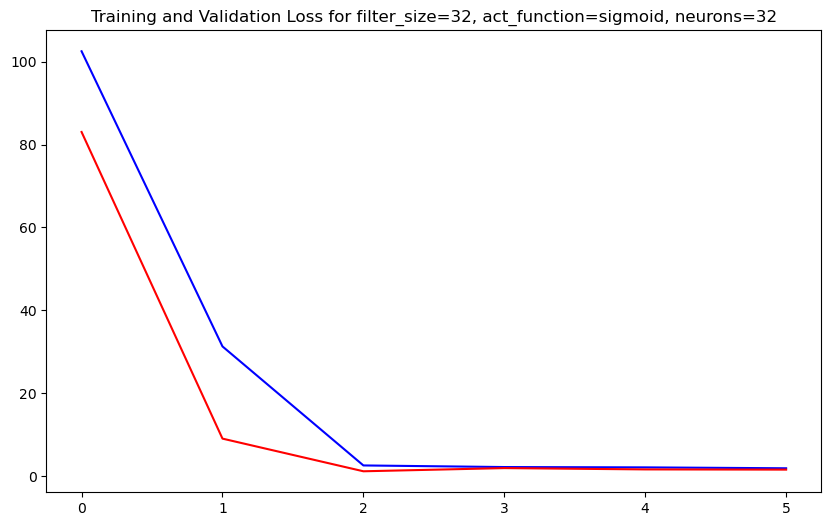


Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 2.

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 5: early stopping


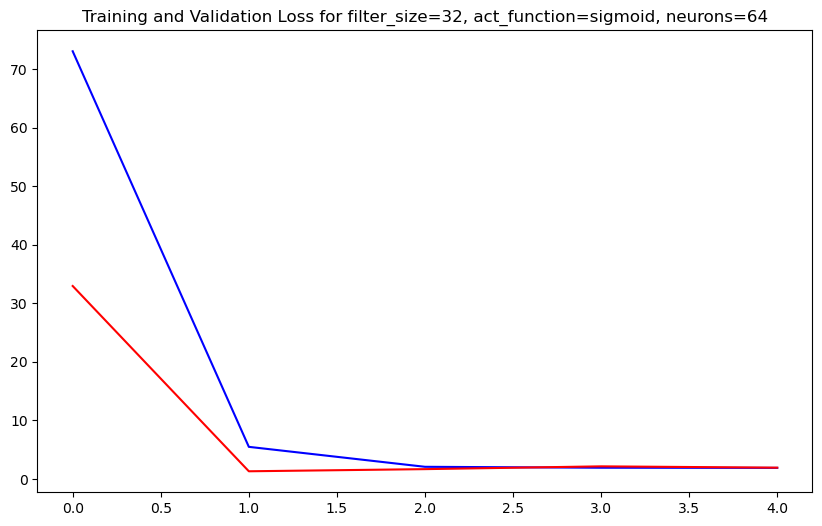


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 12.

Epoch 15: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 15: early stopping


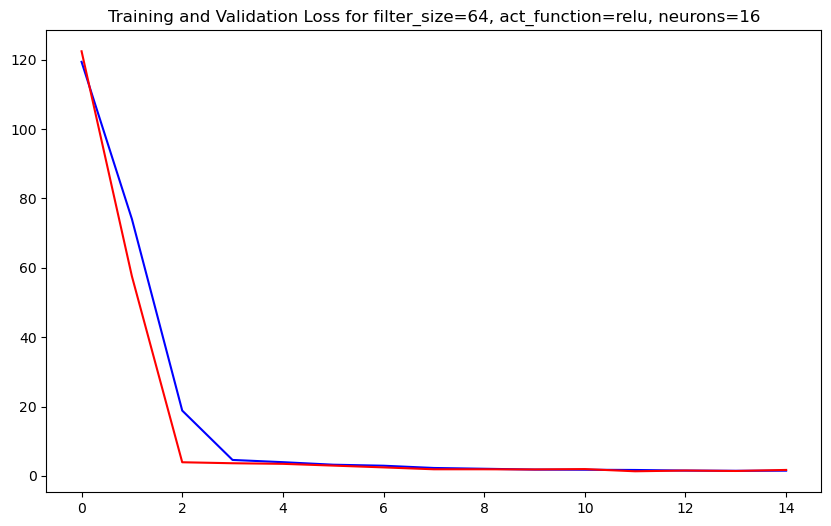


Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 15: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 13.

Epoch 16: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 16: early stopping


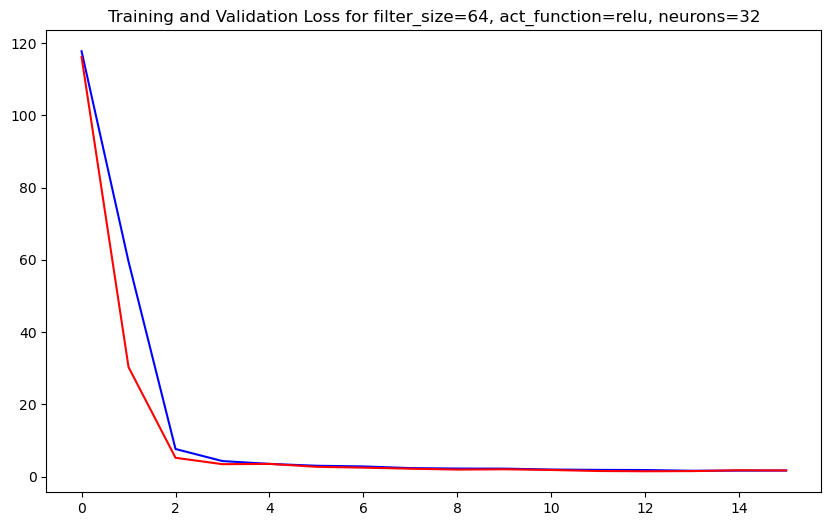


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 8.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping


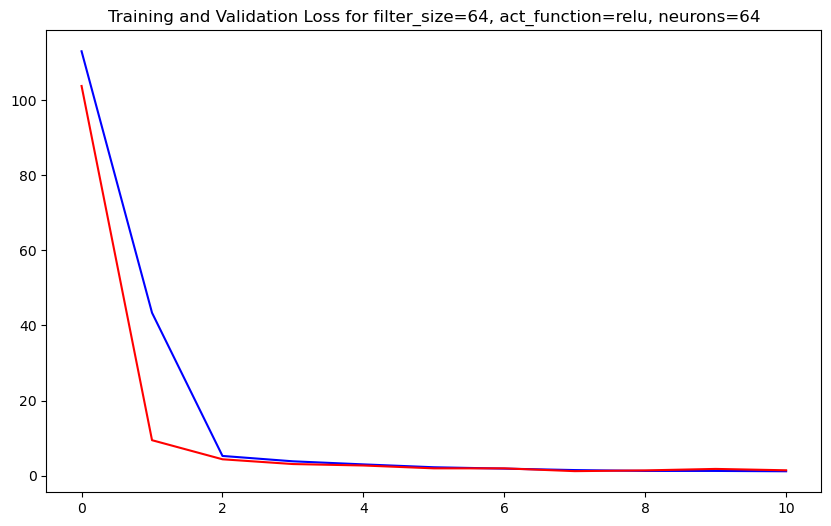


Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 14: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 12.

Epoch 15: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 15: early stopping


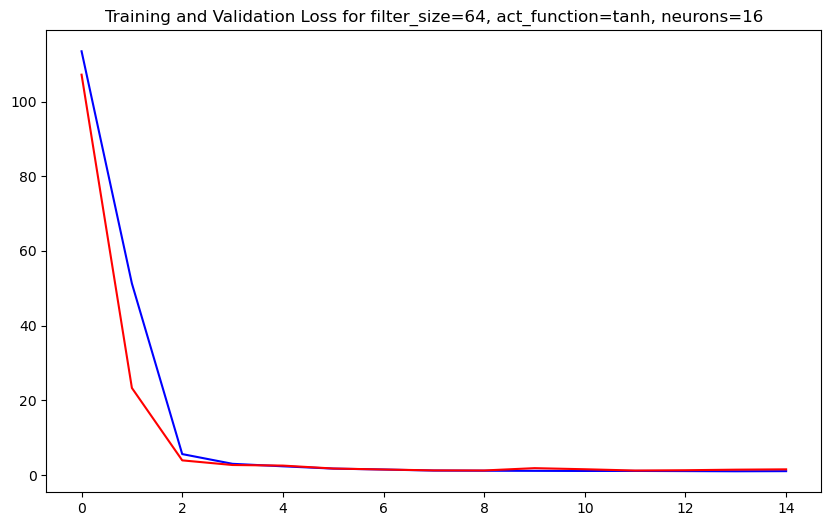


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 6.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 9: early stopping


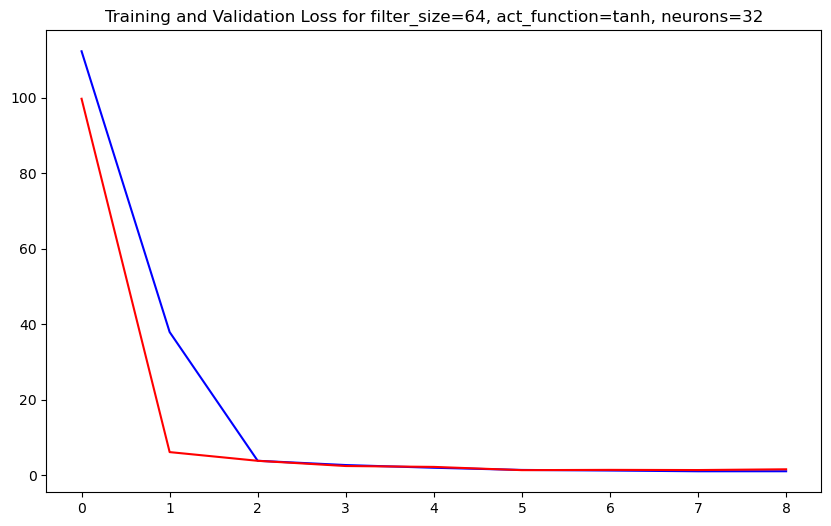


Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 13: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 14: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 12.

Epoch 15: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 15: early stopping


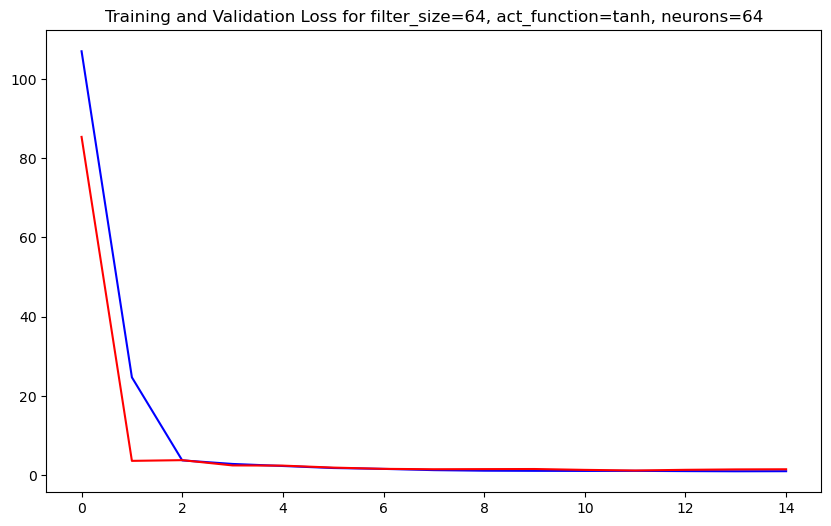


Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 2.

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 5: early stopping


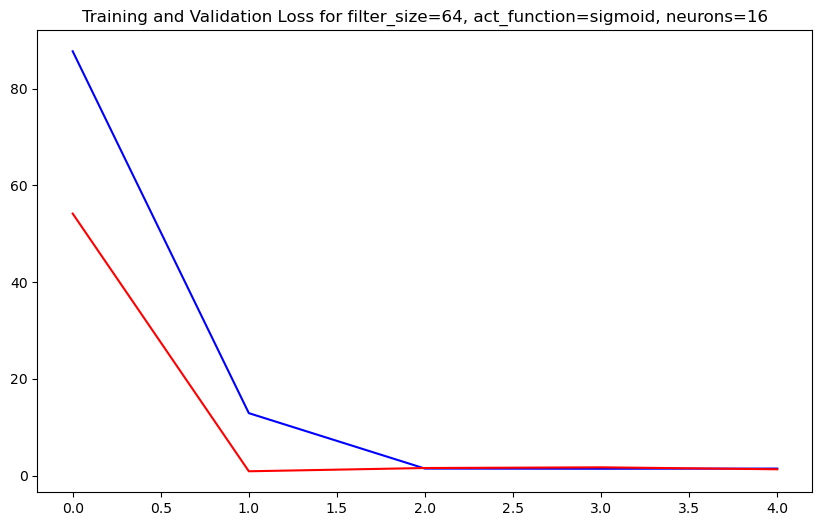


Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 2.

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 5: early stopping


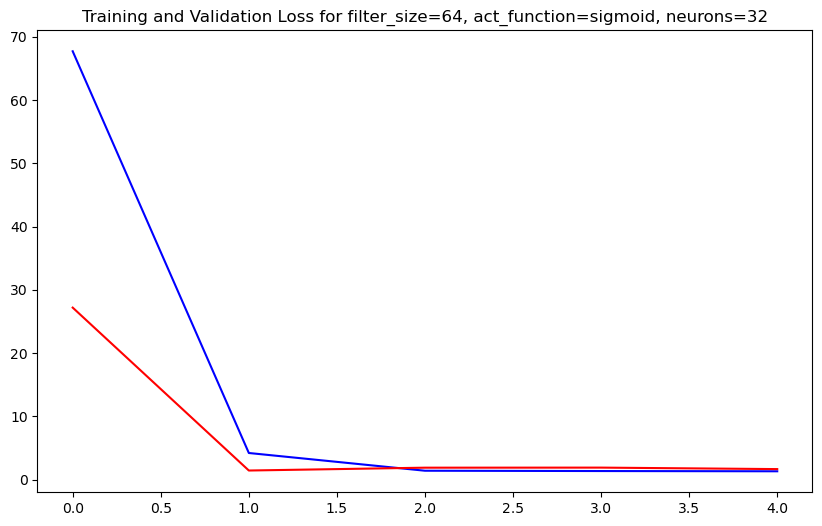


Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 1.

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 4: early stopping


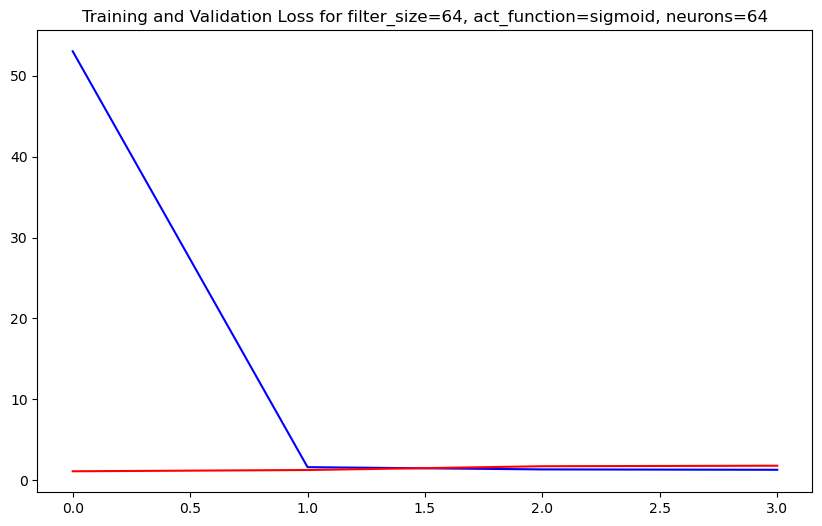


Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 10.

Epoch 13: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 13: early stopping


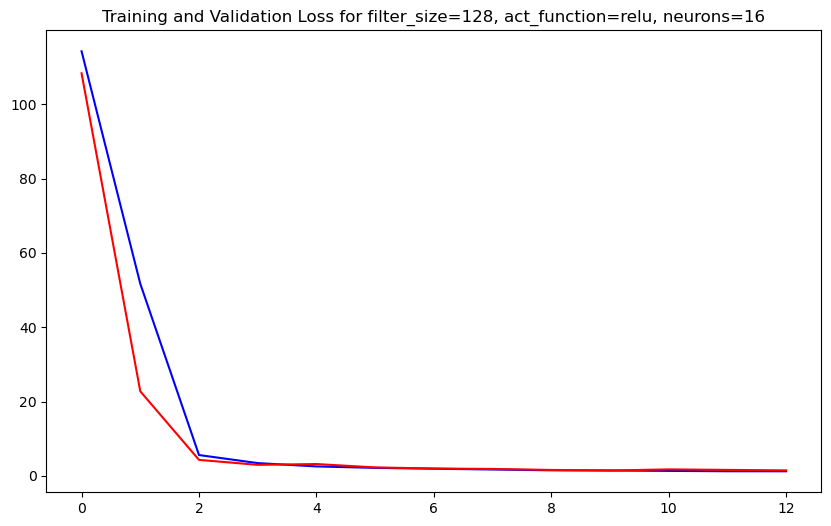


Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 15: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 16: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 14.

Epoch 17: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 17: early stopping


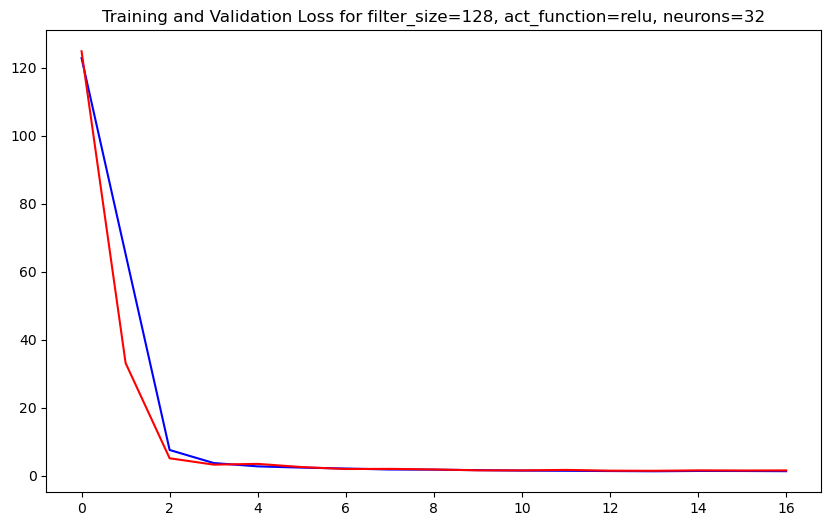


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 11.

Epoch 14: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 14: early stopping


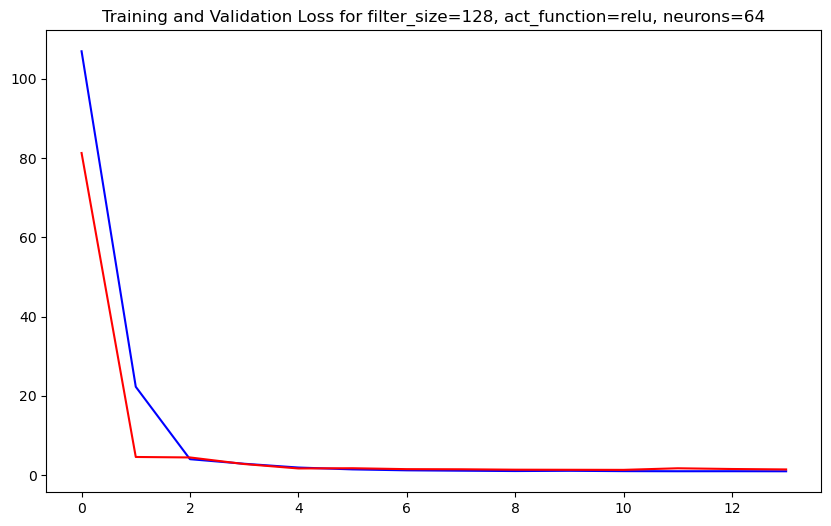


Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 13: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 14: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 12.

Epoch 15: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 15: early stopping


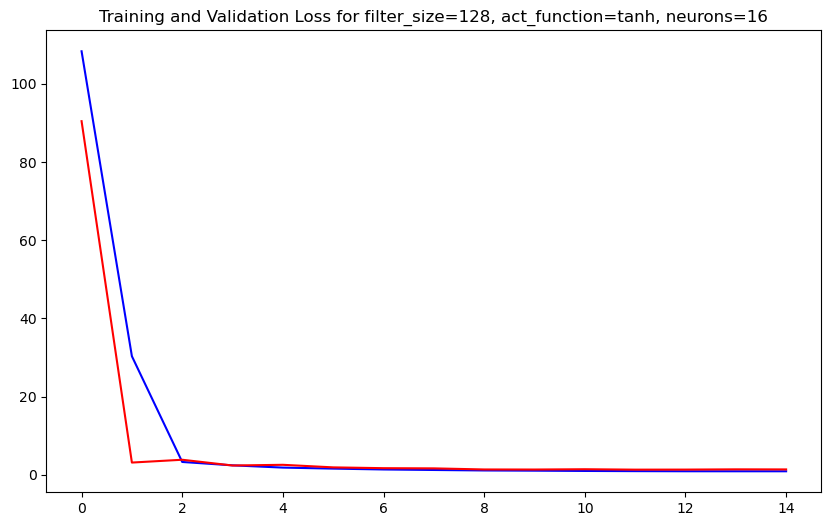


Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 10: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 11: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 9.

Epoch 12: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 12: early stopping


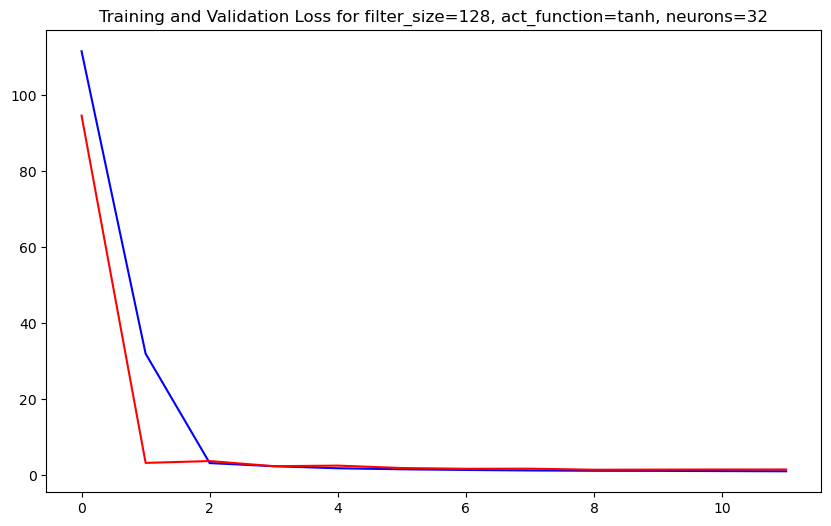


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 5.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 8: early stopping


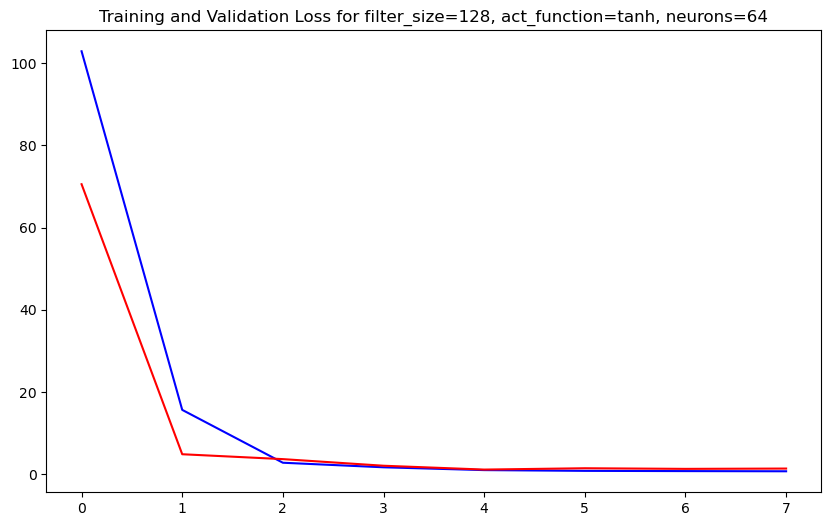


Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 2.

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 5: early stopping


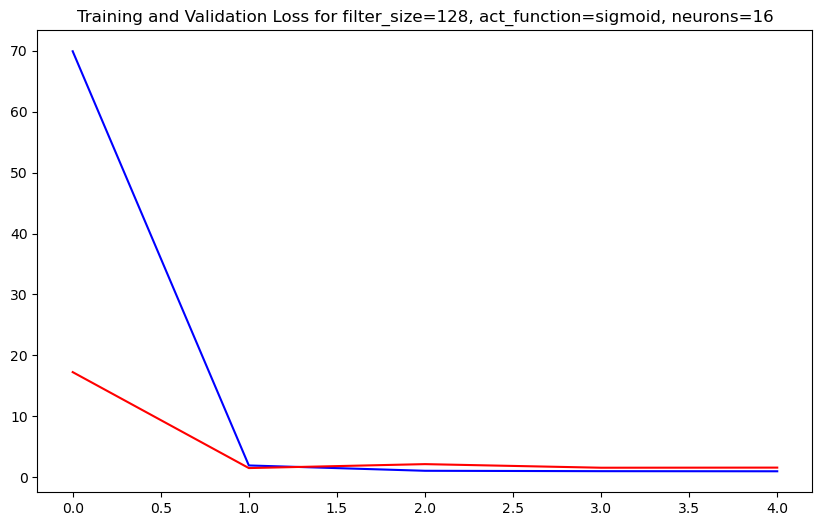


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 8: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 6.

Epoch 9: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 9: early stopping


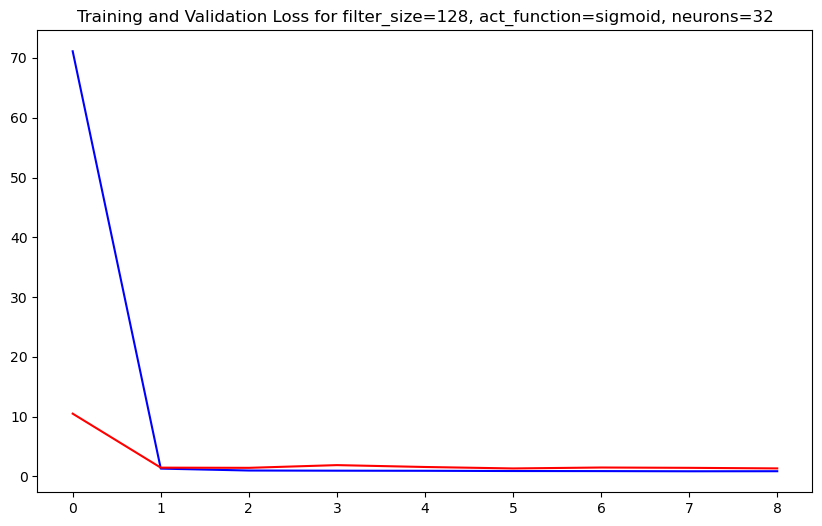


Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 1.

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 4: early stopping


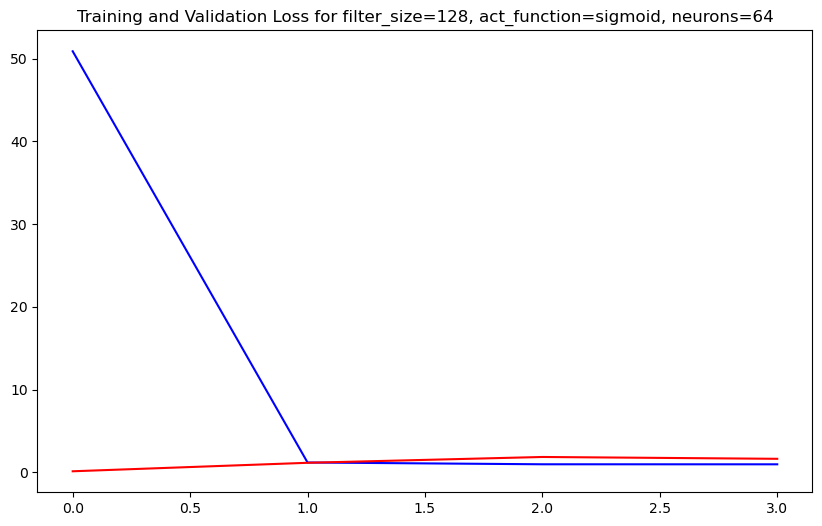

In [18]:
for filter_size in [32, 64, 128]:
    for act_function in ['relu', 'tanh', 'sigmoid']:
        for neurons in [16, 32, 64]:
            model, log = create_model(filter_size, act_function, neurons)